# TEST 1a: 2 Separate Sinusoids Test - Scattered Sampling

## Setup Dataset

In [211]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import gpytorch
from sklearn.datasets import make_blobs

# Define USER parameters for dataset
low_freq = 0.1 # Hz
high_freq = 1 # Hz
n_samples = 1000
num_clusters = 10

# Generate clustered input samples
clustered_input_data, _ = make_blobs(n_samples=n_samples, 
                                     centers=num_clusters, 
                                     cluster_std=0.1, 
                                     center_box=(-10, 10), 
                                     random_state=42)
x_train = torch.Tensor(clustered_input_data[:, 0]) # take the first column of data generated

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.2, n_samples)
y1_low_freq = torch.sin(2 * torch.pi * low_freq * x_train) + torch.Tensor(gw_noise)
y2_high_freq = torch.sin(2 * torch.pi * high_freq * x_train) + torch.Tensor(gw_noise)
y_train = torch.stack([y1_low_freq, y2_high_freq], -1)

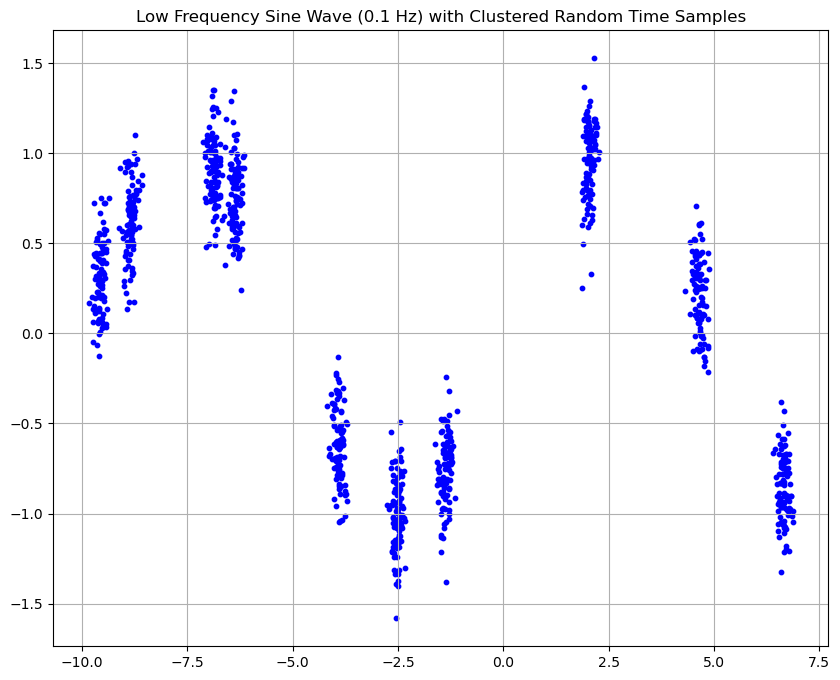

In [212]:
# Plot low frequency sine wave
plt.figure(figsize=(10, 8))
plt.scatter(x_train, y1_low_freq, color='blue', s=10)
plt.title(f'Low Frequency Sine Wave ({low_freq} Hz) with Clustered Random Time Samples')
plt.grid(True)
plt.show()

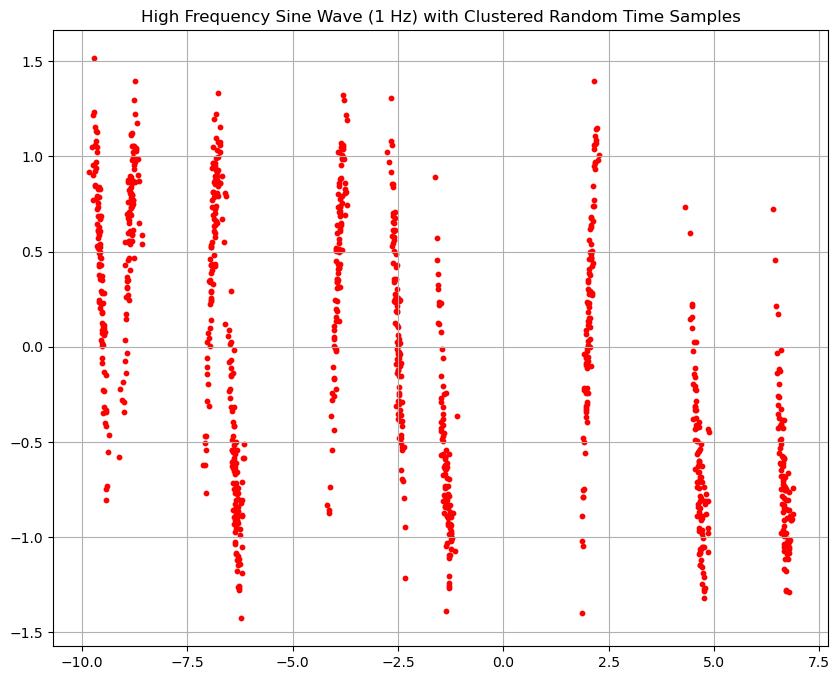

In [213]:
# Plot high frequency sine wave in a separate figure
plt.figure(figsize=(10, 8))
plt.scatter(x_train, y2_high_freq, color='red', s=10)
plt.title(f'High Frequency Sine Wave ({high_freq} Hz) with Clustered Random Time Samples')
plt.grid(True)
plt.show()

## Define the Batch GP model

In [214]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])),
            batch_shape=torch.Size([2])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model_sin1 = BatchIndependentMultitaskGPModel(x_train, y_train, likelihood)

## Train the Batch GP model

In [215]:
# Find optimal model hyperparameters
model_sin1.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model_sin1.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_sin1)

training_epochs = 250
for i in range(training_epochs):
    optimizer.zero_grad()
    output = model_sin1(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_epochs, loss.item()))
    optimizer.step()

Iter 1/250 - Loss: 1.141
Iter 2/250 - Loss: 1.122
Iter 3/250 - Loss: 1.090
Iter 4/250 - Loss: 1.056
Iter 5/250 - Loss: 1.021
Iter 6/250 - Loss: 0.984
Iter 7/250 - Loss: 0.944
Iter 8/250 - Loss: 0.906
Iter 9/250 - Loss: 0.870
Iter 10/250 - Loss: 0.829
Iter 11/250 - Loss: 0.785
Iter 12/250 - Loss: 0.748
Iter 13/250 - Loss: 0.709
Iter 14/250 - Loss: 0.672
Iter 15/250 - Loss: 0.631
Iter 16/250 - Loss: 0.592
Iter 17/250 - Loss: 0.549
Iter 18/250 - Loss: 0.510
Iter 19/250 - Loss: 0.468
Iter 20/250 - Loss: 0.431
Iter 21/250 - Loss: 0.388
Iter 22/250 - Loss: 0.344
Iter 23/250 - Loss: 0.308
Iter 24/250 - Loss: 0.269
Iter 25/250 - Loss: 0.231
Iter 26/250 - Loss: 0.195
Iter 27/250 - Loss: 0.153
Iter 28/250 - Loss: 0.127
Iter 29/250 - Loss: 0.093
Iter 30/250 - Loss: 0.056
Iter 31/250 - Loss: 0.026
Iter 32/250 - Loss: -0.000
Iter 33/250 - Loss: -0.025
Iter 34/250 - Loss: -0.050
Iter 35/250 - Loss: -0.075
Iter 36/250 - Loss: -0.096
Iter 37/250 - Loss: -0.110
Iter 38/250 - Loss: -0.128
Iter 39/250 - 

/Users/lancepharand/ENTER/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 462645.78125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 65/250 - Loss: 3110.159
Iter 66/250 - Loss: 0.036
Iter 67/250 - Loss: 0.025
Iter 68/250 - Loss: 0.005
Iter 69/250 - Loss: 0.002
Iter 70/250 - Loss: -0.027
Iter 71/250 - Loss: -0.002
Iter 72/250 - Loss: -0.003
Iter 73/250 - Loss: -0.026
Iter 74/250 - Loss: -0.036
Iter 75/250 - Loss: -0.026
Iter 76/250 - Loss: -0.042
Iter 77/250 - Loss: -0.035
Iter 78/250 - Loss: -0.036
Iter 79/250 - Loss: -0.019
Iter 80/250 - Loss: -0.030
Iter 81/250 - Loss: -0.034
Iter 82/250 - Loss: -0.012
Iter 83/250 - Loss: -0.007
Iter 84/250 - Loss: -0.012
Iter 85/250 - Loss: -0.020
Iter 86/250 - Loss: -0.020
Iter 87/250 - Loss: -0.011
Iter 88/250 - Loss: -0.009
Iter 89/250 - Loss: -0.008
Iter 90/250 - Loss: 0.002
Iter 91/250 - Loss: -0.005
Iter 92/250 - Loss: -0.004
Iter 93/250 - Loss: 0.005
Iter 94/250 - Loss: -0.003
Iter 95/250 - Loss: 0.001
Iter 96/250 - Loss: -0.009
Iter 97/250 - Loss: -0.000
Iter 98/250 - Loss: -0.003
Iter 99/250 - Loss: -0.009
Iter 100/250 - Loss: 0.012
Iter 101/250 - Loss: 0.004
Iter 1

## Make predictions with the Batch GP model and Plot it

In [216]:
# Set into eval mode
model_sin1.eval()
likelihood.eval()

# Make predictions
# IMP NOTE:    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_test = torch.linspace(-10, 10, 1000)
    predictions = likelihood(model_sin1(x_test))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

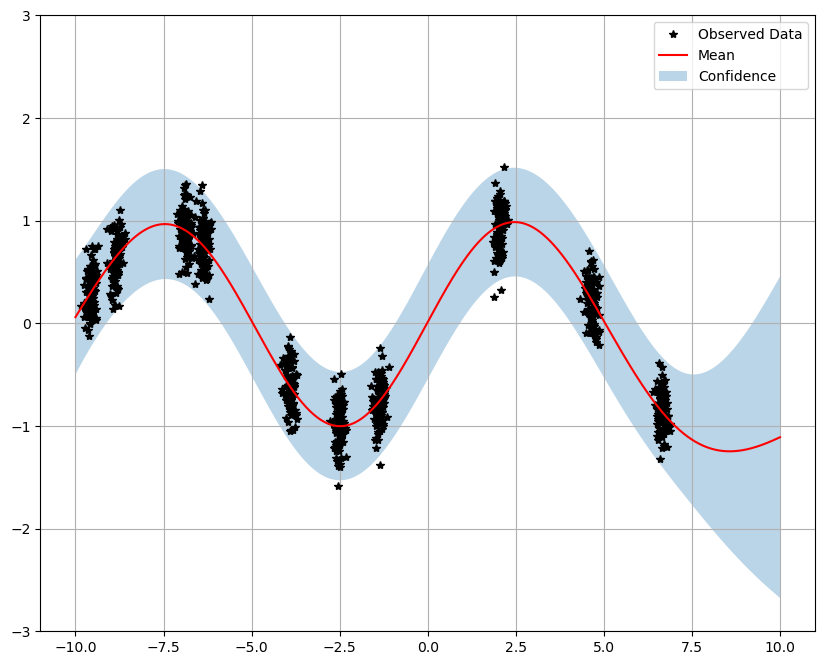

In [217]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.detach().numpy(), y_train[:, 0].detach().numpy(), 'k*')
plt.plot(x_test.numpy(), mean[:, 0].numpy(), 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.3)
plt.ylim([-3, 3])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

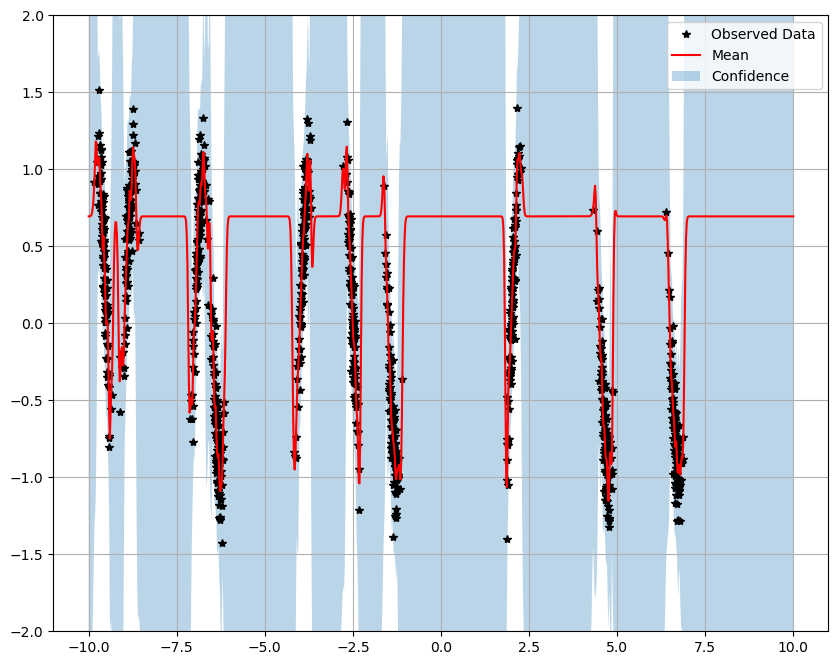

In [218]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.detach().numpy(), y_train[:, 1].detach().numpy(), 'k*')
plt.plot(x_test.numpy(), mean[:, 1].numpy(), 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.3)
plt.ylim([-2, 2])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View Batch GP Model Parameters

In [219]:
for name, param in model_sin1.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}\n")

Parameter name: likelihood.raw_task_noises
Parameter value: Parameter containing:
tensor([-3.2688, -3.3143], requires_grad=True)

Parameter name: likelihood.raw_noise
Parameter value: Parameter containing:
tensor([-3.4523], requires_grad=True)

Parameter name: mean_module.raw_constant
Parameter value: Parameter containing:
tensor([-0.9601,  0.6943], requires_grad=True)

Parameter name: covar_module.raw_outputscale
Parameter value: Parameter containing:
tensor([2.1228, 1.7452], requires_grad=True)

Parameter name: covar_module.base_kernel.raw_lengthscale
Parameter value: Parameter containing:
tensor([[[ 4.2400]],

        [[-3.2263]]], requires_grad=True)



## Define and Fit the BLR Model

In [220]:
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor
import numpy as np

n_order = 5 # order for polynomial features
x_test = np.linspace(-10, 10, 1000)

# Create datasets with polynomial features
x_train_blr = np.vander(x_train.numpy(), n_order + 1, increasing=True)
x_test_blr = np.vander(x_test, n_order + 1, increasing=True)
blr_model_sin1 = MultiOutputRegressor(BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True))

# Fit the model
blr_model_sin1.fit(x_train_blr, y_train.numpy())

MultiOutputRegressor(estimator=BayesianRidge(compute_score=True,
                                             fit_intercept=False, tol=1e-06))

## Make predictions with the BLR model and Plot it

In [221]:
# NOTE: Multi-output regressor doesn't support return_std, so have to pass test data into model through a loop
# Collect the mean and standard deviation for each output
y_means = np.zeros((x_test_blr.shape[0], 2))
y_stds = np.zeros((x_test_blr.shape[0], 2))

# Pass the test data through the model
for i, model in enumerate(blr_model_sin1.estimators_):
    y_mean, y_std = model.predict(x_test_blr, return_std=True)
    y_means[:, i] = y_mean
    y_stds[:, i] = y_std

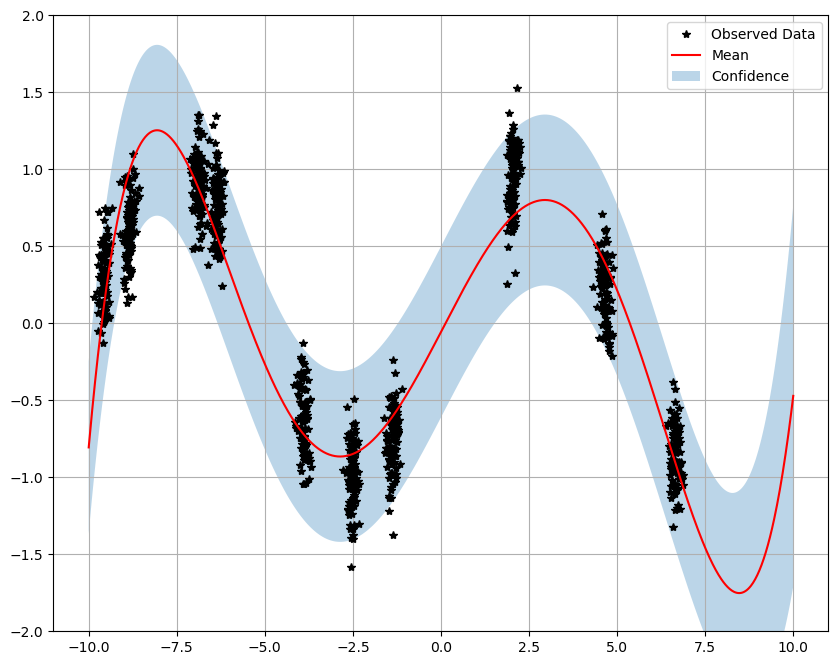

In [222]:
# Plot y1 (low freq sine wave) 
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train[:, 0].numpy(), 'k*')
plt.plot(x_test, y_means[:, 0], 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means[:, 0] - 2 * y_stds[:, 0], y_means[:, 0] + 2 * y_stds[:, 0], alpha=0.3)
plt.ylim([-2, 2])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

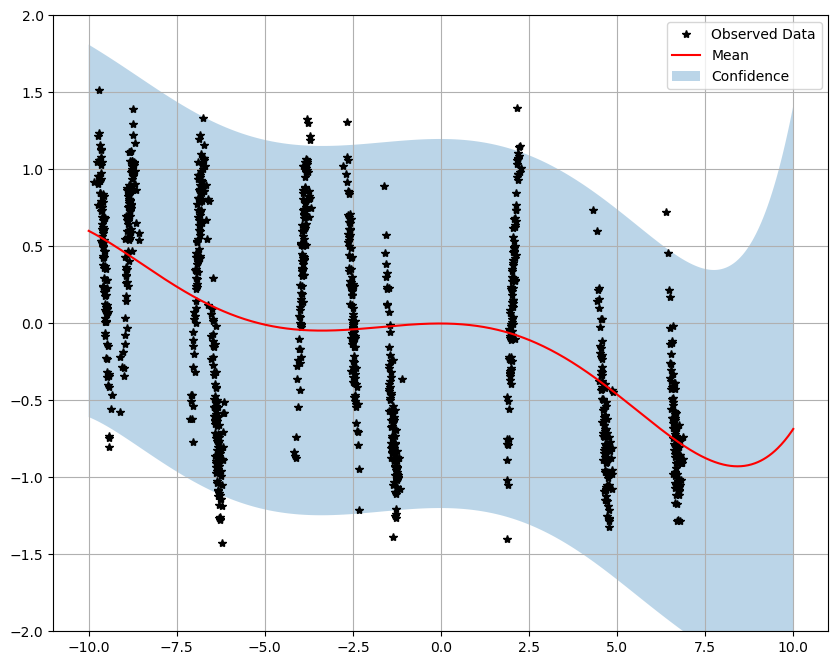

In [223]:
# Plot y2 (high freq sine wave)
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train[:, 1].numpy(), 'k*')
plt.plot(x_test, y_means[:, 1], 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means[:, 1] - 2 * y_stds[:, 1], y_means[:, 1] + 2 * y_stds[:, 1], alpha=0.3)
plt.ylim([-2, 2])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View BLR Model Parameters

In [224]:
# Pass the test data through the model
for i, model in enumerate(blr_model_sin1.estimators_):
    print(f"Model {i + 1}")
    print(f"Alpha (Estimated precision of the noise): {model.alpha_}")
    print(f"Lambda (Estimated precision of the weights): {model.lambda_}")
    print(f"Score (log marginal likelihood): {model.scores_[-1]}")

Model 1
Alpha (Estimated precision of the noise): 13.07280196045825
Lambda (Estimated precision of the weights): 30.274006115136693
Score (log marginal likelihood): -174.71501357515882
Model 2
Alpha (Estimated precision of the noise): 2.7862316312477255
Lambda (Estimated precision of the weights): 24523.26483767728
Score (log marginal likelihood): -926.0116814087252


## Setup Online Variational Conditioning GP Model for Low Freq Sine

In [225]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
from sklearn.datasets import make_blobs

#
# Low Freq Wave
#

# # Define USER parameters for dataset
# low_freq = 0.1 # Hz
# high_freq = 1 # Hz
# n_samples = 1000
# num_clusters = 10

# Generate clustered input samples
clustered_input_data, _ = make_blobs(n_samples=n_samples, 
                                     centers=num_clusters, 
                                     cluster_std=0.1, 
                                     center_box=(-10, 10), 
                                     random_state=42)
x_train = torch.Tensor(clustered_input_data[:, 0]) # take the first column of data generated

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.1, n_samples)
y_train = torch.sin(2 * torch.pi * low_freq * x_train) + torch.Tensor(gw_noise)

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, likelihood):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(torch.randn(25, 1), likelihood)

## Train GP Model

In [226]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

epochs = 500
for i in range(epochs + 1):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train.squeeze())
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print("Iteration: ", i, "\t Loss:", loss.item())

Iteration:  0 	 Loss: 1.6468420028686523
Iteration:  50 	 Loss: 0.7627608776092529
Iteration:  100 	 Loss: 0.7494270205497742
Iteration:  150 	 Loss: 0.748897910118103
Iteration:  200 	 Loss: 0.7488428354263306
Iteration:  250 	 Loss: 0.7488096356391907
Iteration:  300 	 Loss: 0.7487883567810059
Iteration:  350 	 Loss: 0.7487574219703674
Iteration:  400 	 Loss: 0.7487351894378662
Iteration:  450 	 Loss: 0.748710036277771
Iteration:  500 	 Loss: 0.7488164901733398


## Eval GP Model

In [227]:
model.eval()
likelihood.eval()

x_test = torch.linspace(-15, 20, 250).view(-1, 1)
with torch.no_grad():
    posterior = likelihood(model(x_test))
    mean = posterior.mean
    lower, upper = posterior.confidence_region()

## Update Model with new data

In [228]:
# Define USER parameters for dataset
n_new_samples = 50
num_clusters = 3

# Generate clustered input samples
new_clustered_input_data, _ = make_blobs(n_samples=n_new_samples, 
                                         centers=num_clusters, 
                                         cluster_std=0.1, 
                                         center_box=(10, 20), 
                                         random_state=42)
new_x_train = torch.Tensor(new_clustered_input_data[:, 0]) # take the first column of data generated

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.1, n_new_samples)
new_y_train = torch.sin(2 * torch.pi * low_freq * new_x_train) + torch.Tensor(gw_noise)

updated_model = model.variational_strategy.get_fantasy_model(inputs=new_x_train, targets=new_y_train.squeeze())

with torch.no_grad():
    updated_posterior = updated_model.likelihood(updated_model(x_test))
    mean_updated = updated_posterior.mean
    lower_updated, upper_updated = updated_posterior.confidence_region()

/Users/lancepharand/ENTER/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/lancepharand/ENTER/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/lancepharand/ENTER/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


## Plot GP Model for Low Freq Sine Results

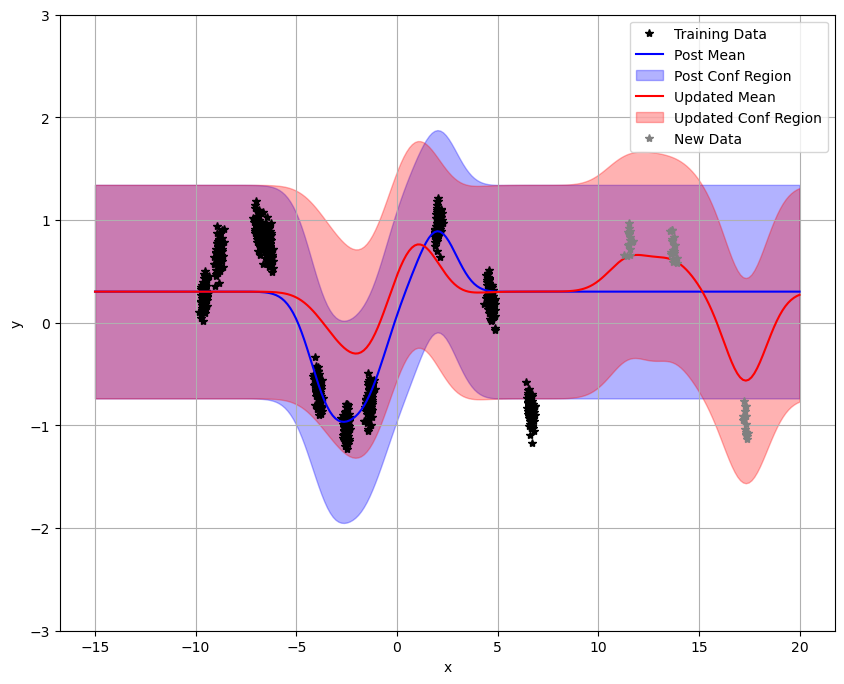

In [229]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train.numpy(), 'k*', label="Training Data") # data
plt.plot(x_test.numpy(), mean.numpy(), 'b-', label="Post Mean") # posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower.squeeze().numpy(),
                 upper.squeeze().numpy(),
                 alpha=0.3,
                 color="blue",
                 label = "Post Conf Region") # Shade in confidence

plt.plot(x_test.numpy(), mean_updated.numpy(), 'r', label="Updated Mean") # updated posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower_updated.squeeze().numpy(),
                 upper_updated.squeeze().numpy(),
                 alpha=0.3,
                 color="red",
                 label="Updated Conf Region") # Shade in confidence
plt.plot(new_x_train, new_y_train.numpy(), linestyle="None", color="gray", marker="*", label="New Data")

plt.ylim([-3, 3])
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Setup Online Variational Conditioning GP Model for High Freq Sine

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch

#
# High Freq Wave
#

# # Define USER parameters for dataset
# low_freq = 0.1 # Hz
# high_freq = 1 # Hz
# n_samples = 1000
# num_clusters = 10

# # Generate clustered input samples
# clustered_input_data, _ = make_blobs(n_samples=n_samples, 
#                                      centers=num_clusters, 
#                                      cluster_std=0.1, 
#                                      center_box=(-10, 10), 
#                                      random_state=42)
x_train = torch.Tensor(clustered_input_data[:, 0]) # take the first column of data generated

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.1, n_samples)
y_train = torch.sin(2 * torch.pi * high_freq * x_train).view(-1, 1) + torch.Tensor(gw_noise).view(-1, 1)


from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, likelihood):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(torch.randn(25, 1), likelihood)

## Train GP Model

In [231]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

epochs = 500
for i in range(epochs + 1):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train.squeeze())
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print("Iteration: ", i, "\t Loss:", loss.item())

Iteration:  0 	 Loss: 1.567652940750122
Iteration:  50 	 Loss: 0.9896759390830994
Iteration:  100 	 Loss: 0.9803000688552856
Iteration:  150 	 Loss: 0.9769985675811768
Iteration:  200 	 Loss: 0.9454171061515808
Iteration:  250 	 Loss: 0.9439038634300232
Iteration:  300 	 Loss: 0.9438801407814026
Iteration:  350 	 Loss: 0.9438672661781311
Iteration:  400 	 Loss: 0.9438521862030029
Iteration:  450 	 Loss: 0.9438374042510986
Iteration:  500 	 Loss: 0.9438223838806152


## Eval GP Model

In [232]:
model.eval()
likelihood.eval()

x_test = torch.linspace(-15, 20, 250).view(-1, 1)
with torch.no_grad():
    posterior = likelihood(model(x_test))
    mean = posterior.mean
    lower, upper = posterior.confidence_region()

## Update Model with new data

In [233]:
# Define USER parameters for dataset
n_test_samples = 50
num_clusters = 3

# Generate clustered input samples
new_clustered_input_data, _ = make_blobs(n_samples=n_test_samples, 
                                         centers=num_clusters, 
                                         cluster_std=0.1, 
                                         center_box=(10, 20), 
                                         random_state=42)
new_x_train = torch.Tensor(new_clustered_input_data[:, 0]) # take the first column of data generated

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.1, n_test_samples)
new_y_train = torch.sin(2 * torch.pi * high_freq * new_x_train) + torch.Tensor(gw_noise)

updated_model = model.variational_strategy.get_fantasy_model(inputs=new_x_train, targets=new_y_train.squeeze())

with torch.no_grad():
    updated_posterior = updated_model.likelihood(updated_model(x_test))
    mean_updated = updated_posterior.mean
    lower_updated, upper_updated = updated_posterior.confidence_region()

## Plot GP Model for High Freq Sine Results

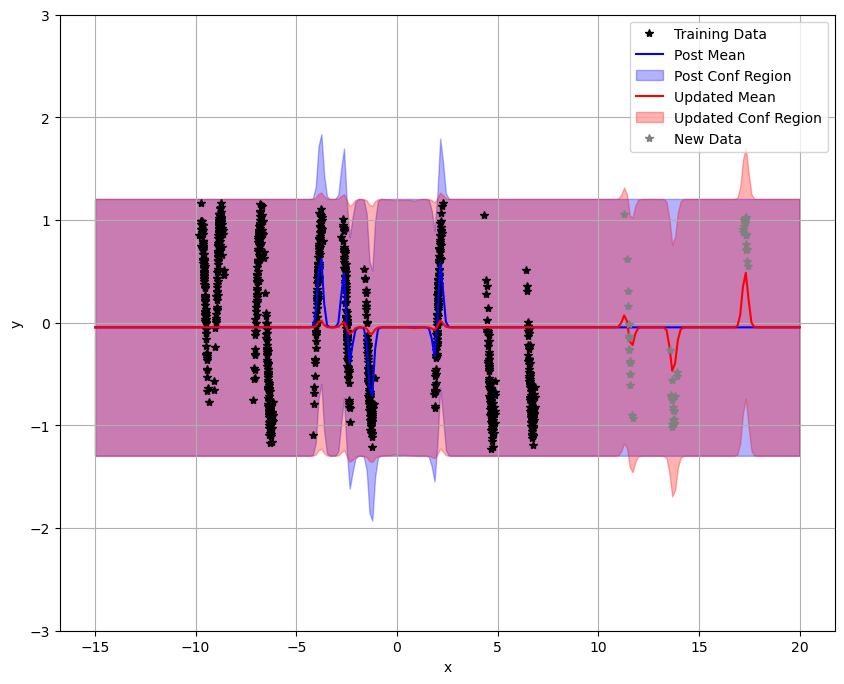

In [234]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train.numpy(), 'k*', label="Training Data") # data
plt.plot(x_test.numpy(), mean.numpy(), 'b-', label="Post Mean") # posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower.squeeze().numpy(),
                 upper.squeeze().numpy(),
                 alpha=0.3,
                 color="blue",
                 label = "Post Conf Region") # Shade in confidence

plt.plot(x_test.numpy(), mean_updated.numpy(), 'r', label="Updated Mean") # updated posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower_updated.squeeze().numpy(),
                 upper_updated.squeeze().numpy(),
                 alpha=0.3,
                 color="red",
                 label="Updated Conf Region") # Shade in confidence
plt.plot(new_x_train, new_y_train.numpy(), linestyle="None", color="gray", marker="*", label="New Data")

plt.ylim([-3, 3])
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Setup BLL NN for Low Freq Sine

In [235]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class BLL_NN(nn.Module):
    def __init__(self, architecture, activation_fn=nn.ReLU):
        super().__init__()
        layers = []
        
        # Initialize Input layer size
        in_size = architecture[0]
        
        # Add hidden layers
        for layer in range(1, len(architecture) - 1):
            out_size = architecture[layer]
            layers.append(nn.Linear(in_size, out_size))
            layers.append(activation_fn())
            in_size = out_size # for next layer 
        
        # Output layer (no activation for the output layer)
        layers.append(nn.Linear(in_size, architecture[-1]))
        
        # Create a sequential model with the layers
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass through the model.
        """
        return self.network(x)
    
    def get_activations(self, x):
        """
        Method to get intermediate activations before the final output layer.
        """
        activations = []
        for layer in self.network[:-1]:  # Ignore the last output layer
            x = layer(x)
            activations.append(x)
        return activations[-1] # Return the final hidden activations
    
    def get_std(self, x_test, x_train, sig_w=1e0, sig_e=1e0):
        Sigma_E = np.eye(x_train.shape[0]) * 1 / sig_e**2          
        Sigma_W = np.eye(architecture[-2]) * 1 / sig_w**2
        
        a_train = self.get_activations(x_train)
        a_hat = self.get_activations(x_test)
        
        cov = a_hat.detach().numpy() @ np.linalg.inv(a_train.T.detach().numpy() @ Sigma_E @ a_train.detach().numpy() 
                                                     + Sigma_W) @ a_hat.T.detach().numpy()
        std2_nn_raw = np.diag(cov).reshape(x_test.shape)
        std_nn_raw = np.sqrt(std2_nn_raw)
        # err_nn_raw = np.abs(y_hat_nn.detach().numpy() - y_test).reshape(y_test.shape)
        return std_nn_raw

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the architecture and create the model
architecture = [1, 50, 50, 1]
model = BLL_NN(architecture, activation_fn=nn.Tanh)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

## Setup Low Freq Sine Dataset

In [236]:
#
# Low Freq Wave
#

# # Define USER parameters for dataset
# low_freq = 0.1 # Hz
# high_freq = 1 # Hz
# n_samples = 1000
# num_clusters = 10

# # Generate clustered input samples
# clustered_input_data, _ = make_blobs(n_samples=n_samples, 
#                                      centers=num_clusters, 
#                                      cluster_std=0.1, 
#                                      center_box=(-10, 10), 
#                                      random_state=42)
x_train = torch.Tensor(clustered_input_data[:, 0]).view(-1, 1) # take the first column of data generated

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.1, n_samples)
y_train = torch.sin(2 * torch.pi * low_freq * x_train).view(-1, 1) + torch.Tensor(gw_noise).view(-1, 1)

## Train BLL NN

In [237]:
# Train model
num_epochs = 500

for epoch in range(num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.6393187046051025
Epoch 10, Loss: 0.4574068486690521
Epoch 20, Loss: 0.23166456818580627
Epoch 30, Loss: 0.15146616101264954
Epoch 40, Loss: 0.11648524552583694
Epoch 50, Loss: 0.10155259817838669
Epoch 60, Loss: 0.09111664444208145
Epoch 70, Loss: 0.08436109870672226
Epoch 80, Loss: 0.07898849248886108
Epoch 90, Loss: 0.0746365413069725
Epoch 100, Loss: 0.07098648697137833
Epoch 110, Loss: 0.06779249757528305
Epoch 120, Loss: 0.06499158591032028
Epoch 130, Loss: 0.06257890164852142
Epoch 140, Loss: 0.06056860461831093
Epoch 150, Loss: 0.058957308530807495
Epoch 160, Loss: 0.05767843872308731
Epoch 170, Loss: 0.05662187933921814
Epoch 180, Loss: 0.05567815527319908
Epoch 190, Loss: 0.0547657310962677
Epoch 200, Loss: 0.053827062249183655
Epoch 210, Loss: 0.052813369780778885
Epoch 220, Loss: 0.051657501608133316
Epoch 230, Loss: 0.05018235743045807
Epoch 240, Loss: 0.04795612767338753
Epoch 250, Loss: 0.04486965760588646
Epoch 260, Loss: 0.04032387211918831
Epoch 270, L

## Obtain BLL Predictions

In [238]:
# Setup Test Data
# x_test = torch.Tensor(clustered_input_data[:, 1]).view(-1, 1)
n_test_samples = 250
x_test = torch.linspace(-10, 10, n_test_samples).view(-1, 1)
gw_noise = np.random.normal(0, 0.1, n_test_samples)
y_test = torch.sin(2 * torch.pi * low_freq * x_test) + torch.Tensor(gw_noise).view(-1, 1)

model.eval()
with torch.no_grad():
    y_hat_nn = model(x_test)

std_nn = model.get_std(x_test, x_train)

## Plot BLL Predictions for Low Freq Sine

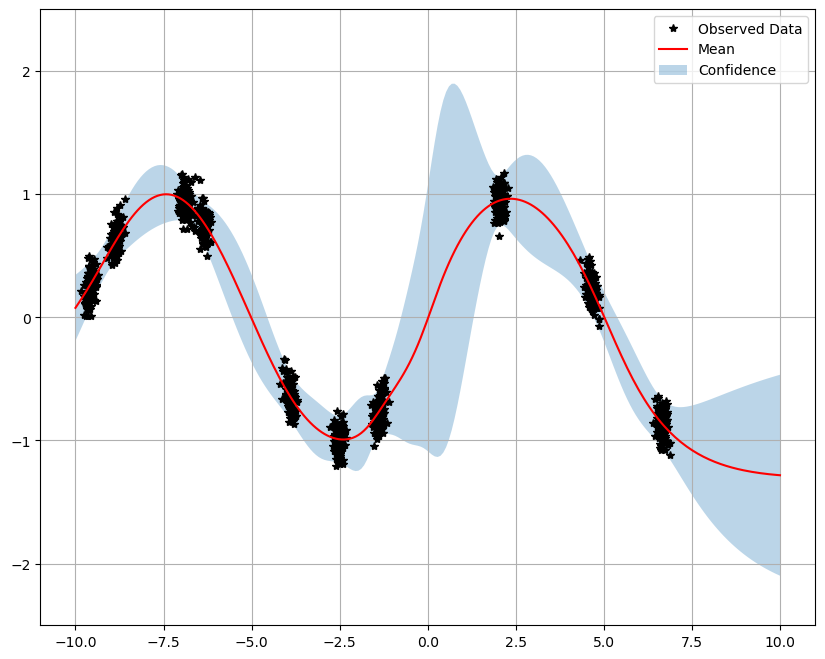

In [239]:
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*')
plt.plot(x_test, y_hat_nn.detach().numpy(), 'r') # Predictive mean 

lower = y_hat_nn.detach().numpy() - 2 * std_nn
upper = y_hat_nn.detach().numpy() + 2 * std_nn

# Shade in confidence 
plt.fill_between(x_test.squeeze(), 
                 lower.squeeze(), 
                 upper.squeeze(), 
                 alpha=0.3)
plt.ylim([-2.5, 2.5])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## Setup BLL NN for High Freq Sine

In [240]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class BLL_NN(nn.Module):
    def __init__(self, architecture, activation_fn=nn.ReLU):
        super().__init__()
        layers = []
        
        # Initialize Input layer size
        in_size = architecture[0]
        
        # Add hidden layers
        for layer in range(1, len(architecture) - 1):
            out_size = architecture[layer]
            layers.append(nn.Linear(in_size, out_size))
            layers.append(activation_fn())
            in_size = out_size # for next layer 
        
        # Output layer (no activation for the output layer)
        layers.append(nn.Linear(in_size, architecture[-1]))
        
        # Create a sequential model with the layers
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass through the model.
        """
        return self.network(x)
    
    def get_activations(self, x):
        """
        Method to get intermediate activations before the final output layer.
        """
        activations = []
        for layer in self.network[:-1]:  # Ignore the last output layer
            x = layer(x)
            activations.append(x)
        return activations[-1] # Return the final hidden activations
    
    def get_std(self, x_test, x_train, sig_w=1e0, sig_e=1e0):
        Sigma_E = np.eye(x_train.shape[0]) * 1 / sig_e**2          
        Sigma_W = np.eye(architecture[-2]) * 1 / sig_w**2
        
        a_train = self.get_activations(x_train)
        a_hat = self.get_activations(x_test)
        
        cov = a_hat.detach().numpy() @ np.linalg.inv(a_train.T.detach().numpy() @ Sigma_E @ a_train.detach().numpy() 
                                                     + Sigma_W) @ a_hat.T.detach().numpy()
        std2_nn_raw = np.diag(cov).reshape(x_test.shape)
        std_nn_raw = np.sqrt(std2_nn_raw)
        # err_nn_raw = np.abs(y_hat_nn.detach().numpy() - y_test).reshape(y_test.shape)
        return std_nn_raw

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the architecture and create the model
architecture = [1, 50, 50, 1]
model = BLL_NN(architecture, activation_fn=nn.Tanh)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

## Setup High Freq Sine Dataset

In [241]:
#
# Low Freq Wave
#

# # Define USER parameters for dataset
# low_freq = 0.1 # Hz
# high_freq = 1 # Hz
# n_samples = 1000
# num_clusters = 10

# # Generate clustered input samples
# clustered_input_data, _ = make_blobs(n_samples=n_samples, 
#                                      centers=num_clusters, 
#                                      cluster_std=0.1, 
#                                      center_box=(-10, 10), 
#                                      random_state=42)
x_train = torch.Tensor(clustered_input_data[:, 0]).view(-1, 1) # take the first column of data generated

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.1, n_samples)
y_train = torch.sin(2 * torch.pi * high_freq * x_train).view(-1, 1) + torch.Tensor(gw_noise).view(-1, 1)

## Train BLL NN

In [242]:
# Train model
num_epochs = 500

for epoch in range(num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.4399449825286865
Epoch 10, Loss: 0.4013676643371582
Epoch 20, Loss: 0.34415489435195923
Epoch 30, Loss: 0.3168039619922638
Epoch 40, Loss: 0.3002316653728485
Epoch 50, Loss: 0.29128673672676086
Epoch 60, Loss: 0.2878580391407013
Epoch 70, Loss: 0.28410986065864563
Epoch 80, Loss: 0.28120818734169006
Epoch 90, Loss: 0.27810153365135193
Epoch 100, Loss: 0.27477166056632996
Epoch 110, Loss: 0.2708803713321686
Epoch 120, Loss: 0.2661849856376648
Epoch 130, Loss: 0.2607061564922333
Epoch 140, Loss: 0.2630535364151001
Epoch 150, Loss: 0.25308793783187866
Epoch 160, Loss: 0.25080156326293945
Epoch 170, Loss: 0.2471265345811844
Epoch 180, Loss: 0.24482908844947815
Epoch 190, Loss: 0.2423136830329895
Epoch 200, Loss: 0.23621821403503418
Epoch 210, Loss: 0.23687435686588287
Epoch 220, Loss: 0.22880452871322632
Epoch 230, Loss: 0.22529880702495575
Epoch 240, Loss: 0.22149379551410675
Epoch 250, Loss: 0.21761150658130646
Epoch 260, Loss: 0.2167934775352478
Epoch 270, Loss: 0.21940

## Obtain BLL Predictions

In [243]:
# Setup Test Data
# x_test = torch.Tensor(clustered_input_data[:, 1]).view(-1, 1)
n_test_samples = 250
x_test = torch.linspace(-10, 10, n_test_samples).view(-1, 1)
gw_noise = np.random.normal(0, 0.1, n_test_samples)
y_test = torch.sin(2 * torch.pi * low_freq * x_test) + torch.Tensor(gw_noise).view(-1, 1)

model.eval()
with torch.no_grad():
    y_hat_nn = model(x_test)

std_nn = model.get_std(x_test, x_train)

## Plot BLL Predictions for High Freq Sine

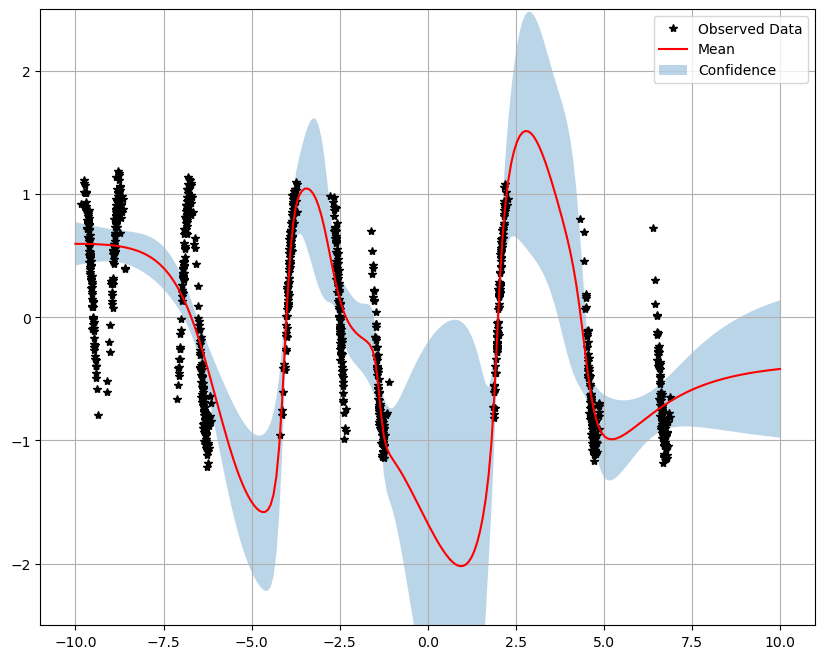

In [244]:
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*')
plt.plot(x_test, y_hat_nn.detach().numpy(), 'r') # Predictive mean 

lower = y_hat_nn.detach().numpy() - 2 * std_nn
upper = y_hat_nn.detach().numpy() + 2 * std_nn

# Shade in confidence 
plt.fill_between(x_test.squeeze(), 
                 lower.squeeze(), 
                 upper.squeeze(), 
                 alpha=0.3)
plt.ylim([-2.5, 2.5])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()